In [2]:
!pip install matplotlib seaborn scikit-learn pandas numpy

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   --- ------------------------------------ 0.8/8.1 MB 4.0 MB/s eta 0:00:02
   ---------- ----------------------------- 2.1/8.1 MB 4.8 MB/s eta 0:00:02
   ------------------- -------------------- 3.9/8.1 MB 6.2 MB/s eta 0:00:01
   ----------------------------- ---------- 6.0/8.1 MB 7.3 MB/s eta 0:00:01
   -------------------------------------- - 7.9/8.1 MB 8.0 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 7.6 MB/s  0:00:01
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 10.6 MB/s  0:00:00
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   --------------- ------------------------ 2.6/7.0 MB 12.3 MB/s eta 0:00:01
   ---------------------------------------  6.8/7.0 MB 16.2 MB/s eta 0:00:01
   ---------------------------------------- 7.0/7.0 MB 15.2 MB/s  0:00:00

   ----------------------------------

In [13]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [14]:
#Raw Data
file_path = r"C:\Users\F8eee\Downloads\Trafficproject.csv"


In [15]:
# Some_CSVs contain special characters
df = pd.read_csv(file_path, encoding='latin1')

In [16]:
# Rename for clarity
df.rename(columns={'Temperature (°C)': 'TempC'}, inplace=True)

In [31]:
# Convert DateTime
df['DateTime'] = pd.to_datetime(df['DateTime'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['DateTime'])  # Drop rows if conversion fails

print(" Raw Data Loaded")
print(df.head())


KeyError: 'DateTime'

In [18]:
# Fill missing values (median for columns, then forward fill as backup)
df = df.fillna(df.median(numeric_only=True))
df = df.ffill()


In [19]:
# Remove duplicates
df = df.drop_duplicates()

In [20]:
# Set index for resampling
df = df.set_index('DateTime')

In [32]:
# Hourly Aggregation
df_hourly = df.groupby('Junction').resample('H').agg({
    'Vehicles': 'sum',
    'TempC': 'median',
    'Rain': 'max',
    'IsEvent': 'max',
    'IsWeekend': 'max'
}).reset_index()

print(" Aggregated Data")
print(df_hourly.head())

 Aggregated Data
   Junction            DateTime  Vehicles  TempC  Rain  IsEvent  IsWeekend
0         1 2015-11-01 00:00:00        15   26.0     0        0          0
1         1 2015-11-01 01:00:00        13   29.0     0        0          1
2         1 2015-11-01 02:00:00        10   28.0     0        0          0
3         1 2015-11-01 03:00:00         7   26.0     0        1          0
4         1 2015-11-01 04:00:00         9   29.0     0        1          1


C:\Users\F8eee\AppData\Local\Temp\ipykernel_13624\2412804891.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.groupby('Junction').resample('H').agg({


In [24]:
# Normalize core features
scaler = StandardScaler()
features_to_norm = ['Vehicles', 'TempC', 'Rain']
df_hourly[features_to_norm] = scaler.fit_transform(df_hourly[features_to_norm])
print("Normalized Data")
print(df_hourly.head())

Normalized Data
   Junction            DateTime  Vehicles     TempC      Rain  IsEvent  \
0         1 2015-11-01 00:00:00 -0.375489 -0.880972 -0.004559        0   
1         1 2015-11-01 01:00:00 -0.471875  0.877343 -0.004559        0   
2         1 2015-11-01 02:00:00 -0.616454  0.291238 -0.004559        0   
3         1 2015-11-01 03:00:00 -0.761034 -0.880972 -0.004559        1   
4         1 2015-11-01 04:00:00 -0.664648  0.877343 -0.004559        1   

   IsWeekend  
0          0  
1          1  
2          0  
3          0  
4          1  


In [33]:
# Feature Engineering - More Unique Features
df_hourly['Hour'] = df_hourly['DateTime'].dt.hour
df_hourly['DayOfWeek'] = df_hourly['DateTime'].dt.weekday
df_hourly['IsMorning'] = (df_hourly['Hour'] < 12).astype(int)  # Unique binary feature
df_hourly['IsPeakHour'] = ((df_hourly['Hour'] >= 8) & (df_hourly['Hour'] <= 10) |
                           (df_hourly['Hour'] >= 17) & (df_hourly['Hour'] <= 19)).astype(int)

# Lag features for more time windows
for lag in [2, 4, 8]:
    df_hourly[f'Lag_{lag}h'] = df_hourly.groupby('Junction')['Vehicles'].shift(lag)

# Drop NaNs
df_hourly = df_hourly.dropna()

print(" Feature Engineering Done")
print(df_hourly.head())


 Feature Engineering Done
    Junction            DateTime  Vehicles  TempC  Rain  IsEvent  IsWeekend  \
8          1 2015-11-01 08:00:00        11   26.0     0        0          0   
9          1 2015-11-01 09:00:00        12   26.0     0        1          0   
10         1 2015-11-01 10:00:00        15   25.0     0        1          1   
11         1 2015-11-01 11:00:00        17   26.0     0        1          0   
12         1 2015-11-01 12:00:00        16   29.0     0        1          1   

    Hour  DayOfWeek  IsMorning  IsPeakHour  Lag_2h  Lag_4h  Lag_8h  
8      8          6          1           1     9.0     9.0    15.0  
9      9          6          1           1     8.0     6.0    13.0  
10    10          6          1           1    11.0     9.0    10.0  
11    11          6          1           0    12.0     8.0     7.0  
12    12          6          0           0    15.0    11.0     9.0  


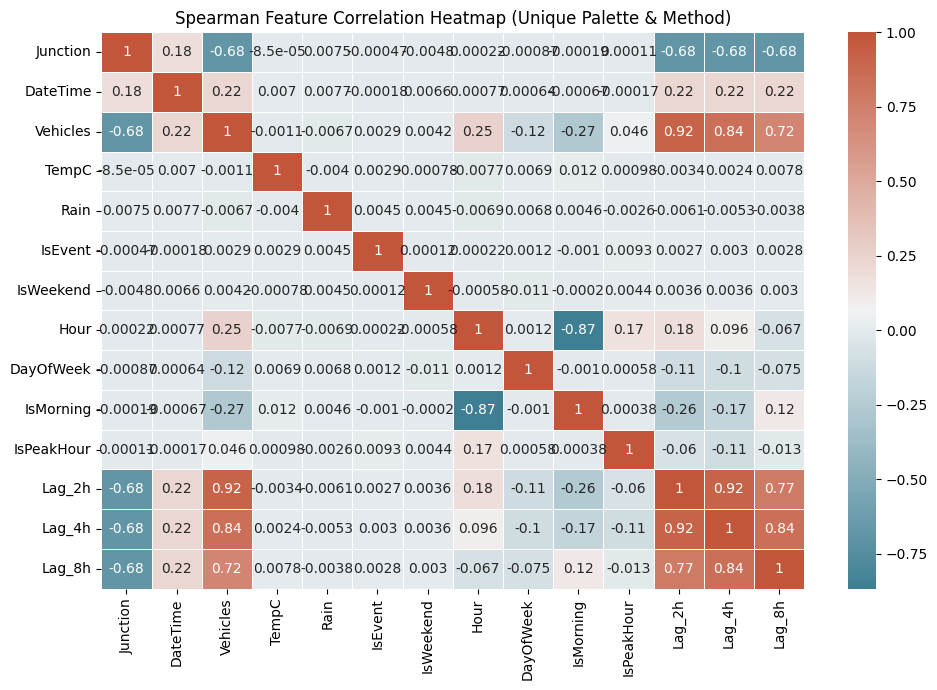

In [26]:
plt.figure(figsize=(10,7))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(df_hourly.corr(method='spearman'), annot=True, cmap=cmap, linewidths=0.5)
plt.title("Spearman Feature Correlation Heatmap (Unique Palette & Method)")
plt.tight_layout()
plt.show()


In [30]:
# Feature importance via Random Forest
X = df_hourly.drop(['Vehicles','DateTime'], axis=1)
y = df_hourly['Vehicles']

rf = RandomForestRegressor(n_estimators=120, random_state=99)
rf.fit(X, y)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(" Feature Importance")
print(feature_importance)

 Feature Importance
       Feature    Importance
9       Lag_2h  8.843360e-01
5         Hour  5.351261e-02
10      Lag_4h  1.664403e-02
11      Lag_8h  1.581973e-02
6    DayOfWeek  8.059862e-03
0     Junction  7.033174e-03
1        TempC  5.507413e-03
7    IsMorning  4.112974e-03
4    IsWeekend  1.855056e-03
3      IsEvent  1.767098e-03
8   IsPeakHour  1.351983e-03
2         Rain  1.308360e-08


In [29]:
# Save Processed Data
output_path = r"C:\Users\F8eee\Downloads\Trafficproject_processed_unique.csv"
df_hourly.to_csv(output_path, index=False)
print(f" Unique processed dataset saved at: {output_path}")

 Unique processed dataset saved at: C:\Users\F8eee\Downloads\Trafficproject_processed_unique.csv
